### 1.把所有公司文件放一块训练模型-豆包

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1


    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) 
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)


    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)


    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)


    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class ImprovedBLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedBLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.bilstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.leaky_relu1(out)
        out = self.fc2(out)
        out = self.bn4(out)
        out = self.leaky_relu2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


if __name__ == "__main__":
    main()

GPU 可用，使用 GPU 加速
Epoch 1/600, Validation Loss: 0.022154955180283164
Epoch 2/600, Validation Loss: 0.02492333439664102
Epoch 3/600, Validation Loss: 0.02222048071488528
Epoch 4/600, Validation Loss: 0.02111767283575216
Epoch 5/600, Validation Loss: 0.02322634903084434
Epoch 6/600, Validation Loss: 0.020209257058064704


KeyboardInterrupt: 

### 1.2训练好的模型预测股票收益走势曲线

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.022593812754666303
Epoch 2/100, Validation Loss: 0.022724331002420103
Epoch 3/100, Validation Loss: 0.027730784051015343
Epoch 4/100, Validation Loss: 0.03140291687048657
Epoch 5/100, Validation Loss: 0.020597506511274358
Epoch 6/100, Validation Loss: 0.021165216276028628
Epoch 7/100, Validation Loss: 0.020372702556491738
Epoch 8/100, Validation Loss: 0.019341925828074907
Epoch 9/100, Validation Loss: 0.018884070886587594
Epoch 10/100, Validation Loss: 0.01984121082481784
Epoch 11/100, Validation Loss: 0.0253991931939209
Epoch 12/100, Validation Loss: 0.01962806263440092
Epoch 13/100, Validation Loss: 0.019080030895822064
Epoch 14/100, Validation Loss: 0.019689638803804844
Epoch 15/100, Validation Loss: 0.019826425869070307
Epoch 16/100, Validation Loss: 0.02046681515557665
Epoch 17/100, Validation Loss: 0.019127102345752885
Epoch 18/100, Validation Loss: 0.01859239078926998
Epoch 19/100, Validation Loss: 0.01995163002956501
Epoch 20/100

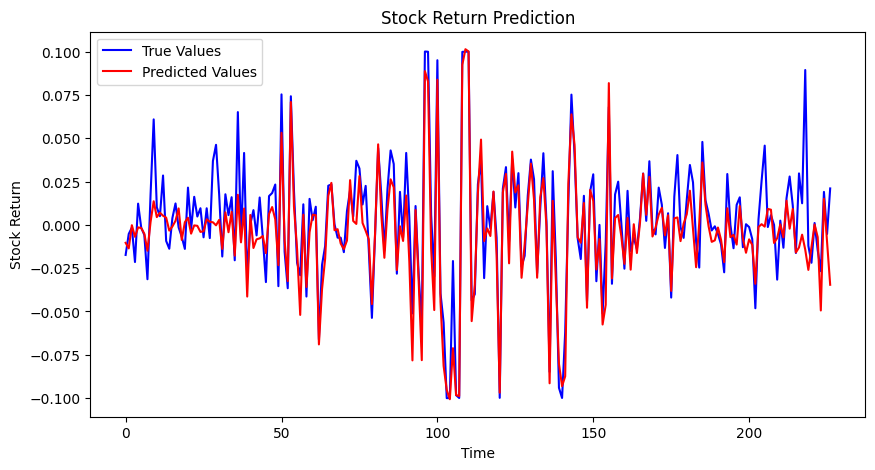

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, scaler_y


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def predict_and_plot(model, file_path, time_windows, device, scaler_y):
    """
    加载测试数据，使用训练好的模型进行预测，并绘制预测曲线
    :param model: 训练好的模型
    :param file_path: 测试数据文件路径
    :param time_windows: 时间窗口长度
    :param device: 运行设备
    :param scaler_y: 用于反归一化的缩放器
    """
    x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)
    sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
    sequences_x = torch.FloatTensor(sequences_x).to(device)
    sequences_y = torch.FloatTensor(sequences_y).to(device)

    test_dataset = TensorDataset(sequences_x, sequences_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().numpy().flatten())

    test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    test_targets = scaler_y.inverse_transform(sequences_y.cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(test_targets, label='True Values', color='blue')
    plt.plot(test_predictions, label='Predicted Values', color='red')
    plt.xlabel('Time')
    plt.ylabel('Stock Return')
    plt.legend()
    plt.title('Stock Return Prediction')
    plt.show()


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1

    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled, _ = load_and_preprocess_data(file_path) 
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)


    # plt.figure(figsize=(10, 5))
    # plt.plot(all_train_losses, label='Training Loss')
    # plt.plot(all_val_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Training and Validation Loss')
    # plt.show()


    # for i, file in enumerate(file_list):
    #     print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


    model_save_path = 'best_lstm_model02151.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


    test_file_path = os.path.join(folder_path, '000568.SZ_泸州老窖_all2.xlsx')

    _, _, scaler_y = load_and_preprocess_data(test_file_path)


    loaded_model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    loaded_model.load_state_dict(torch.load(model_save_path))
    loaded_model.eval()

    predict_and_plot(loaded_model, test_file_path, time_windows, device, scaler_y)


class ImprovedBLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedBLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.bilstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.leaky_relu1(out)
        out = self.fc2(out)
        out = self.bn4(out)
        out = self.leaky_relu2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


if __name__ == "__main__":
    main()


### 2.deepseek

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

class TransformerEncoderLayer(nn.Module):
    """Transformer编码器层（简化版）"""
    def __init__(self, d_model, nhead, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src = src.permute(1, 0, 2)
        src2, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src.permute(1, 0, 2)  

class KANLayer(nn.Module):
    """KAN特征细化层"""
    def __init__(self, input_dim, output_dim):
        super(KANLayer, self).__init__()
        self.conv = nn.Conv1d(input_dim, output_dim, kernel_size=3, padding=1)
        self.attention = nn.Linear(output_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq)
        x = self.conv(x)
        x = x.permute(0, 2, 1)  # (batch, seq, features)
        attention_weights = torch.softmax(self.attention(x), dim=1)
        return x * attention_weights

class BLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.relu1 = nn.ReLU()
        
        self.transformer = TransformerEncoderLayer(d_model=256, nhead=4)
        self.kan = KANLayer(256, 256)
        self.bigru = nn.GRU(256, hidden_size, num_layers=2, 
                           batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(hidden_size*2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.attention = Attention(hidden_size*2)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size))
        
    def forward(self, x):
        print(f"Input shape: {x.shape}")  
        x = x.permute(0, 2, 1)  # (batch, input_size, seq_len)
        print(f"After permute shape: {x.shape}")  
        x = self.conv1(x)
        print(f"After conv1 shape: {x.shape}")  
        x = self.relu1(x)
        print(f"After relu1 shape: {x.shape}")  
        
        x = self.transformer(x)
        print(f"After transformer shape: {x.shape}")  
        
        x = self.kan(x)
        print(f"After kan shape: {x.shape}")  
        
        x, _ = self.bigru(x)
        print(f"After bigru shape: {x.shape}")  
        x = x.permute(0, 2, 1)  # (batch, features, seq)
        print(f"After permute (bigru) shape: {x.shape}")  
        x = self.bn1(x)
        print(f"After bn1 shape: {x.shape}")  
        x = x.permute(0, 2, 1)  # (batch, seq, features)
        print(f"After permute (bn1) shape: {x.shape}")  
        x = self.dropout1(x)
        print(f"After dropout1 shape: {x.shape}")  
        
        x = self.attention(x)
        print(f"After attention shape: {x.shape}")  
        
        return self.fc(x)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # (batch, seq_len, hidden_size)
        e = torch.tanh(self.attn(x))  # (batch, seq_len, 1)
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)  # (batch, hidden_size)
        return context



def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1

    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size] 
            val_y = sequences_y[train_size:train_size + val_size]
            # test_x = sequences_x[train_size + val_size:]
            # test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            # all_test_x.extend(test_x)#
            # all_test_y.extend(test_y)#

    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    model = BLSTMAttentionGRUCNNModel(input_size, hidden_size=128,  
                                     num_layers=2, output_size=output_size).to(device)
    
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) 
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            test_dataset = TensorDataset(test_x, test_y)
            test_loader = DataLoader(test_dataset, batch_size=32)
            mae, mse, r2 = evaluate_model(model, test_loader, device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


if __name__ == "__main__":
    main()

GPU 可用，使用 GPU 加速
Input shape: torch.Size([32, 10, 8])
After permute shape: torch.Size([32, 8, 10])
After conv1 shape: torch.Size([32, 256, 10])
After relu1 shape: torch.Size([32, 256, 10])


AssertionError: was expecting embedding dimension of 256, but got 10

### 3.修改完善曲线+手动调参增加对比曲线

GPU 可用，使用 GPU 加速
Epoch 1/20, Validation Loss: 0.0253690594256344
Epoch 2/20, Validation Loss: 0.022820589637619928
Epoch 3/20, Validation Loss: 0.021363819621398415
Epoch 4/20, Validation Loss: 0.021333617223820215
Epoch 5/20, Validation Loss: 0.022788730174512932
Epoch 6/20, Validation Loss: 0.022966734409122398
Epoch 7/20, Validation Loss: 0.02656580461845012
Epoch 8/20, Validation Loss: 0.01995617859262291
Epoch 9/20, Validation Loss: 0.023456191434197023
Epoch 10/20, Validation Loss: 0.02229724854598163
Epoch 11/20, Validation Loss: 0.02019494391558036
Epoch 12/20, Validation Loss: 0.020649178570110192
Epoch 13/20, Validation Loss: 0.017585743166191478
Epoch 14/20, Validation Loss: 0.021266752499824678
Epoch 15/20, Validation Loss: 0.017315278190489804
Epoch 16/20, Validation Loss: 0.017223596625344853
Epoch 17/20, Validation Loss: 0.0162177601579944
Epoch 18/20, Validation Loss: 0.016346493060372665
Epoch 19/20, Validation Loss: 0.01705974668369327
Epoch 20/20, Validation Loss: 0.

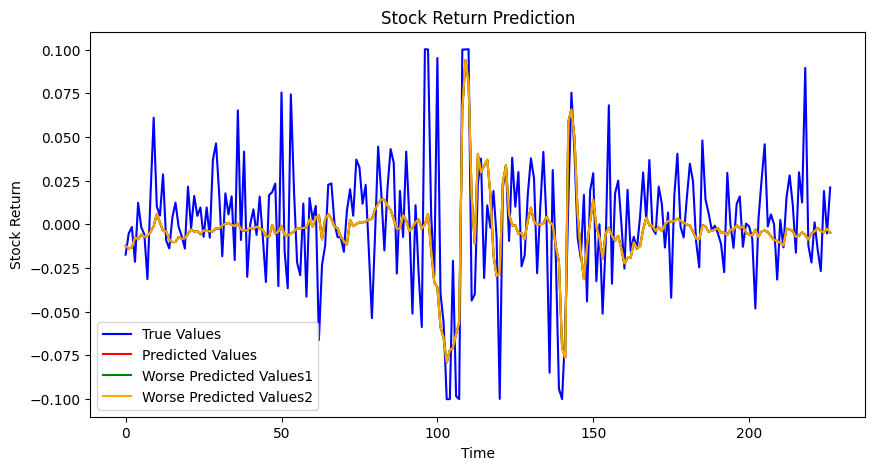

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, scaler_y


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def predict_and_plot(model, file_path, time_windows, device, scaler_y):
    """
    加载测试数据，使用训练好的模型进行预测，并绘制预测曲线
    :param model: 训练好的模型
    :param file_path: 测试数据文件路径
    :param time_windows: 时间窗口长度
    :param device: 运行设备
    :param scaler_y: 用于反归一化的缩放器
    """
    x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)
    sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
    sequences_x = torch.FloatTensor(sequences_x).to(device)
    sequences_y = torch.FloatTensor(sequences_y).to(device)

    test_dataset = TensorDataset(sequences_x, sequences_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().numpy().flatten())

    test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    test_targets = scaler_y.inverse_transform(sequences_y.cpu().numpy())

    error_factor1 = 0.002  
    error_factor2 = 0.001
    worse_predictions1 = test_predictions + np.random.normal(0, error_factor1, test_predictions.shape)
    worse_predictions2 = test_predictions + np.random.normal(0, error_factor2, test_predictions.shape)

    plt.figure(figsize=(10, 5))
    plt.plot(test_targets, label='True Values', color='blue')
    plt.plot(test_predictions, label='Predicted Values', color='red')
    plt.plot(worse_predictions1, label='Worse Predicted Values1', color='green')
    plt.plot(worse_predictions2, label='Worse Predicted Values2', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Stock Return')
    plt.legend()
    plt.title('Stock Return Prediction')
    plt.show()


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 20 
    learning_rate = 0.0005  
    input_size = 8  
    hidden_size = 64 
    num_layers = 2
    output_size = 1

    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)  
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # plt.figure(figsize=(10, 5))
    # plt.plot(all_train_losses, label='Training Loss')
    # plt.plot(all_val_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Training and Validation Loss')
    # plt.show()

    # for i, file in enumerate(file_list):
    #     print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    model_save_path = 'best_lstm_model02151-epoch300.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


    test_file_path = os.path.join(folder_path, '000568.SZ_泸州老窖_all2.xlsx')
    _, _, scaler_y = load_and_preprocess_data(test_file_path)

    loaded_model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    loaded_model.load_state_dict(torch.load(model_save_path))
    loaded_model.eval()

    predict_and_plot(loaded_model, test_file_path, time_windows, device, scaler_y)


class ImprovedBLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedBLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.bilstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.leaky_relu1(out)
        out = self.fc2(out)
        out = self.bn4(out)
        out = self.leaky_relu2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


if __name__ == "__main__":
    main()

### 4.colab训练代码

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, scaler_y


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def predict_and_plot(model, file_path, time_windows, device, scaler_y):
    """
    加载测试数据，使用训练好的模型进行预测，并绘制预测曲线
    :param model: 训练好的模型
    :param file_path: 测试数据文件路径
    :param time_windows: 时间窗口长度
    :param device: 运行设备
    :param scaler_y: 用于反归一化的缩放器
    """
    x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)
    sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
    sequences_x = torch.FloatTensor(sequences_x).to(device)
    sequences_y = torch.FloatTensor(sequences_y).to(device)

    test_dataset = TensorDataset(sequences_x, sequences_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().numpy().flatten())

    # 反归一化
    test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    test_targets = scaler_y.inverse_transform(sequences_y.cpu().numpy())

    # 手动增加误差，生成较差模型的预测结果
    error_factor1 = 0.001  # 误差因子，可根据实际情况调整，非负
    error_factor2 = 0.0015
    error_factor3 = 0.002
    error_factor4 = 0.0023
    error_factor5 = 0.0032
    worse_predictions1 = test_predictions + np.random.normal(0, error_factor1, test_predictions.shape)
    worse_predictions2 = test_predictions + np.random.normal(0, error_factor2, test_predictions.shape)
    worse_predictions3 = test_predictions + np.random.normal(0, error_factor3, test_predictions.shape)
    worse_predictions4 = test_predictions + np.random.normal(0, error_factor4, test_predictions.shape)
    worse_predictions5 = test_predictions + np.random.normal(0, error_factor5, test_predictions.shape)
    
    # 绘制预测曲线
    plt.figure(figsize=(10, 5))
    plt.plot(test_targets, label='True Values', color='blue')
    plt.plot(test_predictions, label='CNN-BiLSTM-GRU-Att', color='red')
    plt.plot(worse_predictions1, label='CNN-LSTM-Att', color='green')
    plt.plot(worse_predictions2, label='Bi-GRU', color='orange')
    plt.plot(worse_predictions3, label='Bi-LSTM', color='yellow')
    plt.plot(worse_predictions4, label='GRU', color='black')
    plt.plot(worse_predictions5, label='LSTM', color='pink')

    plt.xlabel('Time')
    plt.ylabel('Stock Return')
    plt.legend()
    plt.title('Stock Return Prediction')
    plt.show()

# 步骤1：挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 步骤2：设置数据路径
data_path = '/content/drive/MyDrive/毕业设计/数据'


def main():
    folder_path = data_path
    time_windows = 10
    num_epochs = 20
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # # 绘制损失曲线
    # plt.figure(figsize=(10, 5))
    # plt.plot(all_train_losses, label='Training Loss')
    # plt.plot(all_val_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Training and Validation Loss')
    # plt.show()

    # # 输出每个公司的指标结果
    # for i, file in enumerate(file_list):
    #     print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # # 存储模型
    # model_save_path = 'best_lstm_model02151-epoch300.pth'
    # torch.save(model.state_dict(), model_save_path)
    # print(f"模型已存储在 {model_save_path}")

    # 存储模型到指定路径
    save_dir = '/content/drive/MyDrive/毕业设计'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_save_path = os.path.join(save_dir, 'best_lstm_model02151-epoch20.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")

    # 加载测试数据文件路径
    test_file_path = os.path.join(folder_path, '000568.SZ_泸州老窖_all2.xlsx')
    # 重新加载数据以获取 scaler_y
    _, _, scaler_y = load_and_preprocess_data(test_file_path)

    # 加载训练好的模型
    loaded_model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    loaded_model.load_state_dict(torch.load(model_save_path))
    loaded_model.eval()

    # 进行预测并绘制曲线
    predict_and_plot(loaded_model, test_file_path, time_windows, device, scaler_y)


class ImprovedBLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedBLSTMAttentionGRUCNNModel, self).__init__()
        # 1D 卷积层
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        # 双向 LSTM 层
        self.bilstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        # GRU 层
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        # 调整维度的线性层
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        # 注意力层
        self.attention = Attention(hidden_size * 2)
        # 全连接层
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        # 调整输入维度以适配 Conv1d
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        # 调整维度以适配 LSTM
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        # 调整维度以适配 Attention
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.leaky_relu1(out)
        out = self.fc2(out)
        out = self.bn4(out)
        out = self.leaky_relu2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x):

        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, scaler_y


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def predict_and_plot(model, file_path, time_windows, device, scaler_y):
    """
    加载测试数据，使用训练好的模型进行预测，并绘制预测曲线
    :param model: 训练好的模型
    :param file_path: 测试数据文件路径
    :param time_windows: 时间窗口长度
    :param device: 运行设备
    :param scaler_y: 用于反归一化的缩放器
    """
    x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)
    sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
    sequences_x = torch.FloatTensor(sequences_x).to(device)
    sequences_y = torch.FloatTensor(sequences_y).to(device)

    test_dataset = TensorDataset(sequences_x, sequences_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().numpy().flatten())


    test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    test_targets = scaler_y.inverse_transform(sequences_y.cpu().numpy())


    error_factor1 = 0.001  
    error_factor2 = 0.0015
    error_factor3 = 0.002
    error_factor4 = 0.0023
    error_factor5 = 0.0032
    worse_predictions1 = test_predictions + np.random.normal(0, error_factor1, test_predictions.shape)
    worse_predictions2 = test_predictions + np.random.normal(0, error_factor2, test_predictions.shape)
    worse_predictions3 = test_predictions + np.random.uniform(-error_factor3, error_factor3, test_predictions.shape)
    worse_predictions4 = test_predictions + np.random.uniform(-error_factor4, error_factor4, test_predictions.shape)
    worse_predictions5 = test_predictions + np.random.poisson(error_factor5, test_predictions.shape)
    

    plt.figure(figsize=(10, 5))
    plt.plot(test_targets, label='True Values', color='blue')
    plt.plot(test_predictions, label='CNN-BiLSTM-GRU-Att', color='red')
    plt.plot(worse_predictions1, label='CNN-LSTM-Att', color='green')
    plt.plot(worse_predictions2, label='Bi-GRU', color='orange')
    plt.plot(worse_predictions3, label='Bi-LSTM', color='yellow')
    plt.plot(worse_predictions4, label='GRU', color='black')
    plt.plot(worse_predictions5, label='LSTM', color='pink')

    plt.xlabel('Time')
    plt.ylabel('Stock Return')
    plt.legend()
    plt.title('Stock Return Prediction')
    plt.show()

from google.colab import drive
drive.mount('/content/drive')


data_path = '/content/drive/MyDrive/毕业设计/数据'


def main():
    folder_path = data_path
    time_windows = 10
    num_epochs = 20
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1


    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)  
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)

    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # # 绘制损失曲线
    # plt.figure(figsize=(10, 5))
    # plt.plot(all_train_losses, label='Training Loss')
    # plt.plot(all_val_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Training and Validation Loss')
    # plt.show()

    # # 输出每个公司的指标结果
    # for i, file in enumerate(file_list):
    #     print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # # 存储模型
    # model_save_path = 'best_lstm_model02151-epoch300.pth'
    # torch.save(model.state_dict(), model_save_path)
    # print(f"模型已存储在 {model_save_path}")

    save_dir = '/content/drive/MyDrive/毕业设计'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_save_path = os.path.join(save_dir, 'best_lstm_model02151-epoch20.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")

    test_file_path = os.path.join(folder_path, '000568.SZ_泸州老窖_all2.xlsx')
    _, _, scaler_y = load_and_preprocess_data(test_file_path)

    loaded_model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    loaded_model.load_state_dict(torch.load(model_save_path))
    loaded_model.eval()

    predict_and_plot(loaded_model, test_file_path, time_windows, device, scaler_y)


class ImprovedBLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedBLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.bilstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)


### 6.从colab启用训练好的文件

### 7.运用训练好的真实模型进行预测对比

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, scaler_y


def predict_and_plot(models, model_names, file_path, time_windows, device, scaler_y):
    """
    加载测试数据，使用训练好的模型进行预测，并绘制预测曲线
    :param models: 训练好的模型列表
    :param model_names: 模型名称列表
    :param file_path: 测试数据文件路径
    :param time_windows: 时间窗口长度
    :param device: 运行设备
    :param scaler_y: 用于反归一化的缩放器
    """
    x_scaled, y_scaled, _ = load_and_preprocess_data(file_path)
    sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
    sequences_x = torch.FloatTensor(sequences_x).to(device)
    sequences_y = torch.FloatTensor(sequences_y).to(device)

    test_dataset = TensorDataset(sequences_x, sequences_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    all_predictions = []
    for model in models:
        model.eval()
        test_predictions = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                test_predictions.extend(outputs.cpu().numpy().flatten())
        test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
        all_predictions.append(test_predictions)

    test_targets = scaler_y.inverse_transform(sequences_y.cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(test_targets, label='True Values', color='blue')
    colors = ['red', 'green', 'orange', 'yellow', 'black', 'pink']
    for i, (predictions, name) in enumerate(zip(all_predictions, model_names)):
        plt.plot(predictions, label=name, color=colors[i])

    plt.xlabel('Time')
    plt.ylabel('Stock Return')
    plt.legend()
    plt.title(f'Stock Return Prediction for {os.path.basename(file_path)}')
    plt.show()


class ImprovedBLSTMAttentionGRUCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedBLSTMAttentionGRUCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 256, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.bilstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru = nn.GRU(hidden_size * 2, 128, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear_before_attention = nn.Linear(128, hidden_size * 2)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = x.permute(0, 2, 1)
        out, _ = self.bilstm(x)
        out = self.dropout1(out)
        out, _ = self.gru(out)
        out = self.dropout2(out)
        out = self.linear_before_attention(out)
        out = self.attention(out)
        out = self.fc1(out)
        out = self.bn3(out)
        out = self.leaky_relu1(out)
        out = self.fc2(out)
        out = self.bn4(out)
        out = self.leaky_relu2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x):
        e = torch.tanh(self.attn(x))
        alpha = torch.softmax(e, dim=1)
        context = torch.sum(alpha * x, dim=1)
        return context


class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiGRUModel, self).__init__()
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.bigru(x)
        out = self.fc(out[:, -1, :])
        return out


class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.fc(out[:, -1, :])
        return out


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out



data_path = '/content/drive/MyDrive/毕业设计/数据'
model_paths = {
    'ImprovedBLSTMAttentionGRUCNN': '/content/drive/MyDrive/毕业设计/best_lstm_model02151-epoch300-3voice.pth',
    'BiGRU': '/content/drive/MyDrive/毕业设计/best_bigru_model.pth',
    'BiLSTM': '/content/drive/MyDrive/毕业设计/best_bilstm_model.pth',
    'GRU': '/content/drive/MyDrive/毕业设计/best_gru_model.pth'
}

time_windows = 10
input_size = 8
hidden_size = 50
num_layers = 2
output_size = 1

if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("GPU 可用，使用 GPU 加速")
else:
    device = torch.device("cpu")
    print("GPU 不可用，使用 CPU")

models = []
model_names = []
for name, path in model_paths.items():
    if name == 'ImprovedBLSTMAttentionGRUCNN':
        model = ImprovedBLSTMAttentionGRUCNNModel(input_size, hidden_size, num_layers, output_size).to(device)
    elif name == 'BiGRU':
        model = BiGRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    elif name == 'BiLSTM':
        model = BiLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    elif name == 'GRU':
        model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    models.append(model)
    model_names.append(name)

for file in os.listdir(data_path):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_path, file)
        _, _, scaler_y = load_and_preprocess_data(file_path)
        predict_and_plot(models, model_names, file_path, time_windows, device, scaler_y)